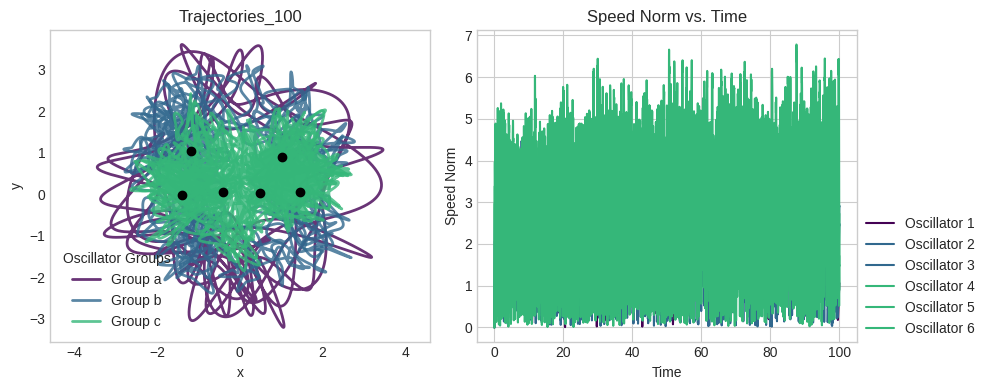

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
seed=100
np.random.seed(seed)

# 参数定义
N = 6  # 振子数量
m = 1.0  # 质量
k_strong = 50.0
k_weak = 1

# 振子分组
# groups = {0:'a',1:'a',2:'a',3:'b',4:'b',5:'b'}
groups = {0:'a',1:'b',2:'b',3:'c',4:'c',5:'c'}
springs = []  # (i, j, k_ij)

for i in range(N):
    for j in range(N):
        if i <= j :
            if groups[i] == groups[j]:
                springs.append((i, j, k_strong))
            else:
                springs.append((i, j, k_weak))

# 初始位置
pos_init = np.array([
    [-1.0, 1.0], [-1.5, 0.0], [-0.5, 0.0],     # group 1
    [1.0, 1.0],  [0.5, 0.0],  [1.5, 0.0]       # group 2
])
pos_init += np.random.randn(N,2)*0.1  # 加一点扰动

# 计算自然长度
L = {}
for i,j,k in springs:
    if groups[i] == groups[j]:
        L[(i,j)] = 0.5 
    else:
        L[(i,j)] = 3

# 初始速度
vel_init = np.zeros((N,2))

# 状态展开
y0 = np.concatenate([pos_init.flatten(), vel_init.flatten()])

def deriv(t, y):
    pos = y[:2*N].reshape(N,2)
    vel = y[2*N:].reshape(N,2)
    acc = np.zeros_like(pos)
    # 弹簧力
    for i,j,k_ij in springs:
        diff = pos[i] - pos[j]
        d = np.linalg.norm(diff)
        if d == 0:
            continue
        force = -k_ij*(d - L[(i,j)]) * (diff/d)
        acc[i] += force/m
        acc[j] -= force/m  # 反作用
    dydt = np.concatenate([vel.flatten(), acc.flatten()])
    return dydt

# 积分
t_span = [0, 100]
t_eval = np.linspace(0, 100, 10000)
sol = solve_ivp(deriv, t_span, y0, t_eval=t_eval)

traj = sol.y[:2*N,:].reshape(N,2,-1)
vels = sol.y[2*N:,:].reshape(N,2,-1)
vnorm = np.linalg.norm(vels, axis=1)  # 每个振子的速度模长

# 轨迹图
unique_groups = sorted(list(set(groups.values()))) 
color_map = {group: plt.cm.viridis(i/len(unique_groups)) for i, group in enumerate(unique_groups)}  
plt.figure(figsize=(10,4))
plt.style.use('seaborn-v0_8-whitegrid')
plt.subplot(1,2,1)
legend_handles = {} 
for i in range(N):
    group = groups[i] 
    color = color_map[group]  
    line, = plt.plot(traj[i,0,:], traj[i,1,:], color=color, linewidth=2, alpha=0.8)
    if group not in legend_handles:  
        legend_handles[group] = line  

plt.scatter(pos_init[:,0], pos_init[:,1], c='k', zorder=10, label='Initial')
plt.legend(legend_handles.values(), [f'Group {g}' for g in legend_handles.keys()],   
              title="Oscillator Groups",  
              loc='best')  
plt.axis('equal')
plt.title(f"Trajectories_{seed}")
plt.xlabel('x'); plt.ylabel('y')
plt.grid()

# 速度模长图
plt.subplot(1,2,2)
for i in range(N):
    group = groups[i] 
    color = color_map[group]  
    plt.plot(t_eval, vnorm[i], color=color, label=f"Oscillator {i+1}")
plt.title("Speed Norm vs. Time")
plt.xlabel("Time")
plt.ylabel("Speed Norm")
plt.legend(loc=[1.01,0])
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
data_frame = pd.DataFrame(sol.y.T)
data_index = data_frame.reset_index()
data_index.to_csv('../dataset/Spring/6_group2_k0.csv', index=False)

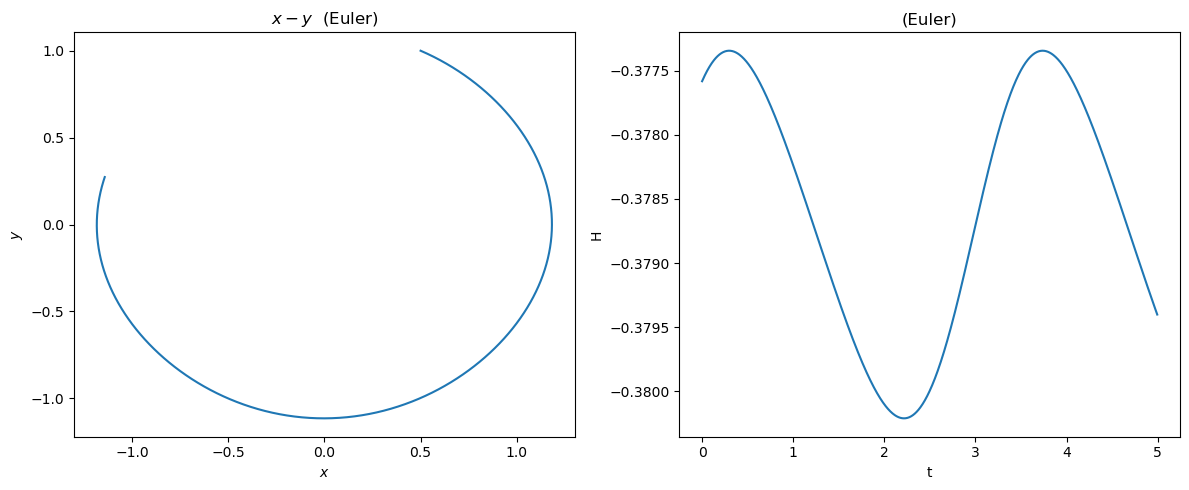

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 系统参数
def dynamics(t, z):
    x, y = z
    dxdt = y
    dydt = -np.sin(x)
    return [dxdt, dydt]

# 哈密顿量
def hamiltonian(x, y):
    return 0.5 * y**2 - np.cos(x)

# 辛积分的简版实现（Velocity Verlet）
def symplectic_euler(x0, y0, h, n):
    x = np.zeros(n)
    y = np.zeros(n)
    x[0], y[0] = x0, y0
    for i in range(n - 1):
        y[i+1] = y[i] - h * np.sin(x[i])         # 先更新动量
        x[i+1] = x[i] + h * y[i+1]               # 再用更新后的动量更新位置
    return x, y

# 参数
x0, y0 = 0.5, 1
h = 0.005
n = 1000
x, y = symplectic_euler(x0, y0, h, n)
t = np.arange(n) * h

# 计算哈密顿量
H = 0.5 * y**2 - np.cos(x)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(x, y)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("$x-y$  (Euler)")

plt.subplot(1,2,2)
plt.plot(t, H)
plt.xlabel("t")
plt.ylabel("H")
plt.title("(Euler)")
plt.tight_layout()
plt.show()